## Upgrade & Import Libraries

In [1]:
# This command upgrades the 'numexpr' library using pip
!pip install --upgrade numexpr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.2/375.2 kB 8.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: numexpr
    Found existing installation: numexpr 2.8.8
    Uninstalling numexpr-2.8.8:
      Successfully uninstalled numexpr-2.8.8


In [2]:
# Import necessary libraries and modules from SageMaker and boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.inputs import TrainingInput
import boto3
import os
import numpy as np

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## Set Up SageMaker Session and Role

In [3]:
# Create a SageMaker session, which manages interactions with SageMaker services
sagemaker_session = sagemaker.Session()

# Get the IAM execution role used for SageMaker to access AWS resources
role = get_execution_role()

# Get the AWS region associated with the SageMaker session
region = sagemaker_session.boto_region_name

In [4]:
print(role)
print(region)

arn:aws:iam::637423178109:role/LabRole
us-east-1


## Data Loading

In [5]:
# Import the pandas library as 'pd' for data manipulation and analysis
import pandas as pd

# Import the train_test_split function from scikit-learn for data splitting
from sklearn.model_selection import train_test_split

In [6]:
burnout_data = pd.read_csv('burnoutdata.csv')

In [7]:
burnout_data

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52
...,...,...,...,...,...,...,...,...,...
22745,fffe31003500370039003100,2008-12-30,Female,Service,No,1.0,3.0,NaN,0.41
22746,fffe33003000350031003800,2008-01-19,Female,Product,Yes,3.0,6.0,6.7,0.59
22747,fffe390032003000,2008-11-05,Male,Service,Yes,3.0,7.0,NaN,0.72
22748,fffe33003300320036003900,2008-01-10,Female,Service,No,2.0,5.0,5.9,0.52


## Data Cleaning

In [8]:
burnout_data.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,22750.000000,21369.000000,20633.000000,21626.000000
mean,2.178725,4.481398,5.728188,0.452005
std,1.135145,2.047211,1.920839,0.198226
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.310000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


In [9]:
# Designation is a score of an employee's seniority, rated from 0.0 to 5.0
# Resource Allocation is a score of an employee's work hour load, rated from 1.0 to 10.0
# Mental Fatigue is a score of an employee's stress, rated from 0.0 to 10.0
# Burn Rate is a float in the range of 0.0 to 1.0

In [10]:
# Dropping Employee ID which is a non-numerical field
burnout_data = burnout_data.drop(['Employee ID'], axis=1)

In [11]:
# Checking for missing values (NaN)

burnout_data.isna()

,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
22745,False,False,False,False,False,False,True,False
22746,False,False,False,False,False,False,False,False
22747,False,False,False,False,False,False,True,False
22748,False,False,False,False,False,False,False,False


In [12]:
# Removing rows with missing data from the DataFrame
burnout_data = burnout_data.dropna()

In [13]:
# Checking that all missing data has been removed
burnout_data.isna().mean()

Date of Joining         0.0
Gender                  0.0
Company Type            0.0
WFH Setup Available     0.0
Designation             0.0
Resource Allocation     0.0
Mental Fatigue Score    0.0
Burn Rate               0.0
dtype: float64

In [14]:
# Renaming attributes to more sensible names

burnout_data = burnout_data.rename({'Date of Joining': 'Start_Date',
                                    'Company Type': 'Service',
                                    'WFH Setup Available': 'WFH_Status',
                                    'Designation': 'Seniority',
                                    'Resource Allocation': 'Work_Hour_Load',
                                    'Mental Fatigue Score': 'Mental_Fatigue',
                                    'Burn Rate': 'Burn_Rate'
                                   }, axis = 1)

In [15]:
# Convert Start_Date data format from string to int for processing

burnout_data['Start_Date'] = burnout_data['Start_Date'].str.replace("-","").astype(int)

In [ ]:
# Identifying the range of start dates

start_date_min = burnout_data['Start_Date'].min()
print("Min: ", start_date_min)

start_date_max = burnout_data['Start_Date'].max()
print("Max: ", start_date_max)

In [78]:
# Min-max scaling start dates to accentuate the differences in start dates rather than the large absolute value
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
burnout_data['Start_Date'] = scaler.fit_transform(burnout_data[['Start_Date']])

In [16]:
burnout_data['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [17]:
# One-hot encoding gender attribute data
burnout_data['Gender'] = burnout_data['Gender'].replace({'Male': 1,
                                                         'Female': 0}).ffill()

/tmp/ipykernel_9758/2899508213.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  burnout_data['Gender'] = burnout_data['Gender'].replace({'Male': 1,


In [19]:
burnout_data['Service'].value_counts()

Service
Service    12174
Product     6416
Name: count, dtype: int64

In [20]:
# One-hot encoding company type attribute data

burnout_data['Service'] = burnout_data['Service'].replace({'Service': 1,
                                                           'Product': 0}).ffill()

/tmp/ipykernel_9758/1420026879.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  burnout_data['Service'] = burnout_data['Service'].replace({'Service': 1,


In [21]:
# Drop all rows with Service = 0, leaving only service companies in the DataFrame

service_column = ['Service']
burnout_data = burnout_data.replace(0, np.nan).dropna(axis=0, how='any', subset=service_column).fillna(0)

In [22]:
# Check that all product company rows have been removed
burnout_data['Service'].describe()

count    12174.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: Service, dtype: float64

In [23]:
# Drop the Service attribute

burnout_data = burnout_data.drop(['Service'], axis=1)

In [24]:
burnout_data['WFH_Status'].value_counts()

WFH_Status
Yes    6565
No     5609
Name: count, dtype: int64

In [25]:
# One-hot encoding WFH Status attribute data

burnout_data['WFH_Status'] = burnout_data['WFH_Status'].replace({'Yes': 1,
                                                                 'No': 0}).ffill()

/tmp/ipykernel_9758/2491054149.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  burnout_data['WFH_Status'] = burnout_data['WFH_Status'].replace({'Yes': 1,


In [26]:
# Viewing cleaned data
burnout_data

,Start_Date,Gender,WFH_Status,Seniority,Work_Hour_Load,Mental_Fatigue,Burn_Rate
0,20080930,0.0,0,2.0,3.0,3.8,0.16
1,20081130,1.0,1,1.0,2.0,5.0,0.36
3,20081103,1.0,1,1.0,1.0,2.6,0.20
4,20080724,0.0,0,3.0,7.0,6.9,0.52
6,20080102,0.0,0,3.0,6.0,7.9,0.62
...,...,...,...,...,...,...,...
22735,20080726,1.0,0,3.0,7.0,7.3,0.64
22736,20080418,1.0,1,4.0,7.0,7.7,0.65
22738,20081223,1.0,1,0.0,1.0,4.9,0.29
22739,20080206,1.0,0,2.0,5.0,8.5,0.67


In [72]:
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

INFO:matplotlib.font_manager:generated new fontManager


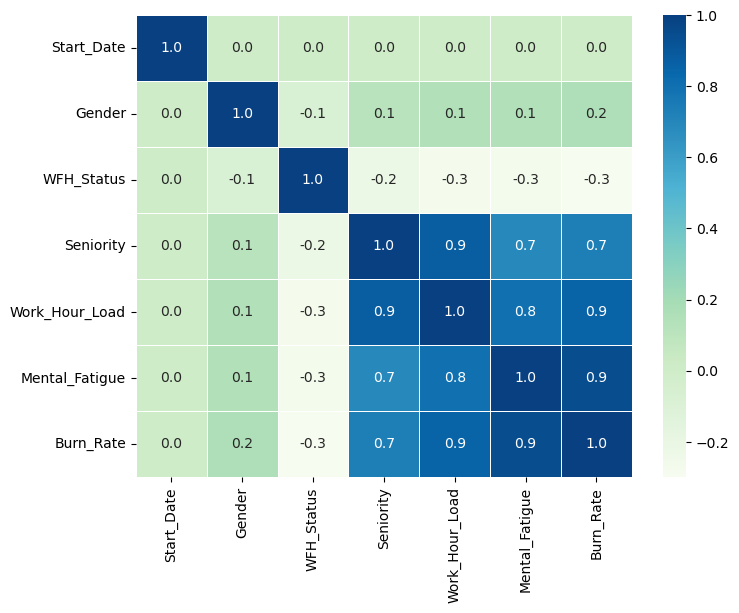

In [79]:
# Correlation Heatmap with Seaborn
# Setting up the size of the Matplotlib figure
f, ax = plt.subplots(figsize=(8,6))

sns.heatmap(burnout_data.corr(), cmap="GnBu", annot=True, linewidths=0.5,fmt='.1f', ax=ax)

plt.show()

In [80]:
# Sorting Correlation Values
burnout_data.corr().Burn_Rate.sort_values()

WFH_Status       -0.299770
Start_Date        0.002155
Gender            0.160129
Seniority         0.735499
Work_Hour_Load    0.854853
Mental_Fatigue    0.944698
Burn_Rate         1.000000
Name: Burn_Rate, dtype: float64

## Preparing The Training and Testing Data

In [27]:
# The target variable attribute is called 'Burn_Rate'

# Create the feature X as the dataset without the target
X = burnout_data.drop('Burn_Rate', axis=1)

# Create the target variable Y as the burn rate, kept as a float
y = burnout_data['Burn_Rate']

# Splitting the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Concatenate the features and labels back into one DataFrame for training data
burnout_train_data = pd.concat([y_train, X_train], axis=1)

# Concatenate the features and labels back into one DataFrame for validation data
burnout_test_data = pd.concat([y_test, X_test], axis=1)

# Save the training data to a CSV file without headers and indices
burnout_train_data.to_csv('Burnout_train.csv', header=False, index=False)

# Save the validation data to a CSV file without headers and indices
burnout_test_data.to_csv('Burnout_test.csv', header=False, index=False)

In [29]:
# Define Amazon S3 bucket and prefix for data storage
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/burnout/regression'

# Paths to local data files
local_train = 'Burnout_train.csv'
local_test = 'Burnout_test.csv'

# Upload the local training data to the specified S3 bucket and prefix
train_uri = sagemaker_session.upload_data(local_train, bucket=bucket, key_prefix=prefix)

# Upload the local validation data to the specified S3 bucket and prefix
test_uri = sagemaker_session.upload_data(local_test, bucket=bucket, key_prefix=prefix)

In [30]:
# Print the S3 URI for the training data
print("Training URI: ", train_uri)

# Print the S3 URI for the validation data
print("Validation URI: ", test_uri)

Training URI:  s3://sagemaker-us-east-1-637423178109/sagemaker/burnout/regression/Burnout_train.csv
Validation URI:  s3://sagemaker-us-east-1-637423178109/sagemaker/burnout/regression/Burnout_test.csv


## Get the Linear Learner Image URI

In [31]:
from sagemaker import image_uris

# Retrieve the container image URI for the SageMaker Linear Learner algorithm
container = image_uris.retrieve(framework='linear-learner', region=region)

print("Container: ", container)

Container:  382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


## Configuring the SageMaker Linear Learner Estimator

In [32]:
# Calculate the number of rows and features in the burnout_data DataFrame
num_rows, num_features = burnout_data.shape

# Print the number of rows and features
print("Number of Rows: ", num_rows)
print("Number of Features: ", num_features)

Number of Rows:  12174
Number of Features:  7


In [33]:
# Create a SageMaker Linear Learner estimator
linear_learner = sagemaker.estimator.Estimator(container,
                                               role,
                                               instance_count=1,
                                               instance_type='ml.m5.large',
                                               output_path=f's3://{bucket}/{prefix}/output',
                                               sagemaker_session=sagemaker_session)

# Set hyperparameters for the Linear Learner
linear_learner.set_hyperparameters(feature_dim=6, # Number of input features excluding target
                                   mini_batch_size=64, # Size of mini-batches for training. Using more than standard 32 due to large number of rows
                                   predictor_type='regressor', # We are performing a regression
                                   normalize_data=True, # Normalize input features
                                   normalize_label=True) # Normalize target variable

## Training the Model

In [34]:
# Fit the SageMaker Linear Learner estimator to the training and testing data 
linear_learner.fit({'train': TrainingInput(train_uri, content_type='text/csv'),
                    'validation': TrainingInput(test_uri, content_type='text/csv')})

INFO:sagemaker:Creating training-job with name: linear-learner-2024-03-20-18-40-20-791


2024-03-20 18:40:21 Starting - Starting the training job...
2024-03-20 18:40:37 Starting - Preparing the instances for training...
2024-03-20 18:41:16 Downloading - Downloading input data......
2024-03-20 18:41:55 Downloading - Downloading the training image......
2024-03-20 18:43:11 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/20/2024 18:43:16 INFO 139961683208000] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss'

## Hyperparameter Tuning

In [43]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter

# Defining hyperparameter ranges to tune
hyperparameter_ranges = {
    'learning_rate': ContinuousParameter(0.0001, 0.1),
    'mini_batch_size': IntegerParameter(16, 64)
}

# Creating a HyperparameterTuner object
tuner = HyperparameterTuner(linear_learner,
                            objective_metric_name='validation:rmse',
                            objective_type='Minimize',
                            hyperparameter_ranges=hyperparameter_ranges,
                            max_jobs=10,
                            max_parallel_jobs=2)

# Launch the hyperparameter tuning job
tuner.fit({'train': TrainingInput(train_uri, content_type='text/csv'),
           'validation': TrainingInput(test_uri, content_type='text/csv')})

INFO:sagemaker:Creating hyperparameter tuning job with name: linear-learner-240320-1904


.............................................................................................................!


## Deploy the Endpoint

### Check to see if the Endpoint exists and if it does delete it

In [58]:
EndpointConfig="regression-linear-learner-endpoint"
Endpoint="regression-linear-learner-endpoint"

In [66]:
def delete_sagemaker_endpoint_config(endpoint_name):
    # Initialize SageMaker Client
    sagemaker = boto3.client('sagemaker', region_name=region)
    
    try:
        # Check if the endpoint configuration exists
        reponse = sagemaker.describe_endpoint_config(EndpointConfigName=endpoint_name)
        
        # If the configuration exists, delete it
        if reponse:
            sagemaker.delete_endpoint_config(EndpointConfigName=endpoint_name)
            print(f"Endpoint configuration '{endpoint_name}' has been deleted.")
        
        return True # Deletion successful
    
    except Exception as e:
        error_message = str(e)
        
        if "Could not find endpoint configuration" in error_message:
            print(f"Endpoint configuration '{endpoint_name}' not found. No action taken.")
            return True  # Configuration not found, exit gracefully
        else:
            print(f"Error deleting SageMaker endpoint configuration: {error_message}")
            return False  # Deletion failed
    
def delete_sagemaker_endpoint(endpoint_name):
    # Initialize SageMaker Client
    sagemaker = boto3.client('sagemaker', region_name=region)
    
    try:
        # Check if the endpoint exists
        response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
        
        # If the endpoint exists, delete it
        if response:
            sagemaker.delete_endpoint(EndpointName=endpoint_name)
            print(f"Endpoint '{endpoint_name}' has been deleted.")
        
        return True # Deletion successful
    
    except Exception as e:
        error_message = str(e)
        
        if "Could not find endpoint" in error_message:
            print(f"Endpoint '{endpoint_name}' not found. No action taken.")
            return True  # Endpoint not found, exit gracefully
        else:
            print(f"Error deleting SageMaker endpoint: {error_message}")
            return False  # Deletion failed

In [67]:
# Delete the Endpoint and Config
result_endpoint_config = delete_sagemaker_endpoint_config(Endpoint)
result_endpoint = delete_sagemaker_endpoint(Endpoint)

if result_endpoint_config and result_endpoint:
    print("Success!")
else:
    print("Failure.")

Endpoint configuration 'regression-linear-learner-endpoint' has been deleted.
Endpoint 'regression-linear-learner-endpoint' has been deleted.
Success!


In [118]:
# Get the best training job name from the tuner
best_training_job = tuner.best_training_job()

# Create a model from the best training job
best_model = sagemaker.estimator.Estimator.attach(best_training_job)

linear_predictor = best_model.deploy(
    initial_instance_count=1, # Number of initial instances
    instance_type='ml.m5.large', # Type of instance for serving the endpoint
    endpoint_name=Endpoint
)


2024-03-20 19:10:53 Starting - Found matching resource for reuse
2024-03-20 19:10:53 Downloading - Downloading the training image
2024-03-20 19:10:53 Training - Training image download completed. Training in progress.
2024-03-20 19:10:53 Uploading - Uploading generated training model
2024-03-20 19:10:53 Completed - Resource reused by training job: linear-learner-240320-1904-008-84fd04fa

INFO:sagemaker:Creating model with name: linear-learner-2024-03-20-20-46-15-046


INFO:sagemaker:Creating endpoint-config with name regression-linear-learner-endpoint
INFO:sagemaker:Creating endpoint with name regression-linear-learner-endpoint


-------!

## Query the Endpoint

In [119]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Set the serializer to CSV
linear_predictor.serializer = CSVSerializer()

# Set the deserializer to JSON
linear_predictor.deserializer = JSONDeserializer()

In [120]:
# Sample hardcoded data point
# Feature order: Start_Date, Gender, WFH_Status, Seniority, Work_Hour_Load, Mental_Fatigue
sample_data = [20080507, 1, 0, 3, 8, 8]

# Convert the sample data to a CSV string
query_data_csv = ','.join([str(item) for item in sample_data])

# Querying the model and getting a prediction
response = linear_predictor.predict(query_data_csv)

# Print out the prediction
print("Predicted value:", response['predictions'][0]['score'])

Predicted value: 0.7272987365722656


In [123]:
actual_values = y_test.tolist()

X_test_list = X_test.values.tolist()

query_data_csv = []
for point in X_test_list:
    query = ','.join([str(item) for item in point])
    query_data_csv.append(query)

predicted_values = []
for query in query_data_csv:
    prediction = linear_predictor.predict(query)
    predicted_values.append(prediction)
print(predicted_values)


[{'predictions': [{'score': 0.527923583984375}]}, {'predictions': [{'score': 0.316253662109375}]}, {'predictions': [{'score': -0.02849578857421875}]}, {'predictions': [{'score': 0.5089588165283203}]}, {'predictions': [{'score': 0.5972728729248047}]}, {'predictions': [{'score': 0.28835487365722656}]}, {'predictions': [{'score': 0.384185791015625}]}, {'predictions': [{'score': 0.41179466247558594}]}, {'predictions': [{'score': 0.08864021301269531}]}, {'predictions': [{'score': 0.4310474395751953}]}, {'predictions': [{'score': 0.4951305389404297}]}, {'predictions': [{'score': 0.4024486541748047}]}, {'predictions': [{'score': 0.2798480987548828}]}, {'predictions': [{'score': 0.6029815673828125}]}, {'predictions': [{'score': 0.5787868499755859}]}, {'predictions': [{'score': 0.2670936584472656}]}, {'predictions': [{'score': 0.6024589538574219}]}, {'predictions': [{'score': 0.22373580932617188}]}, {'predictions': [{'score': 0.6709156036376953}]}, {'predictions': [{'score': 0.21978759765625}]}

## Delete the Endpoint and Config

In [117]:
# Delete the Endpoint and Config
result_endpoint_config = delete_sagemaker_endpoint_config(Endpoint)
result_endpoint = delete_sagemaker_endpoint(Endpoint)

if result_endpoint_config and result_endpoint:
    print("Success!")
else:
    print("Failure.")

Endpoint configuration 'regression-linear-learner-endpoint' has been deleted.
Endpoint 'regression-linear-learner-endpoint' has been deleted.
Success!
